In [2]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from pylab import rcParams
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Датасет "Oakland Crime Statistics 2011 to 2016" был взят с:
    https://www.kaggle.com/cityofoakland/oakland-crime-statistics-2011-to-2016
(This dataset is distributed under the following licenses: Open Data Commons Public Domain Dedication and License, NA)
В нем содержатся записи о преступлениях, совершенных в городе Окленд с 2011 по 2016 года. 

Каждое из преступлений в датасете описаывется набором данных, в том числе датой и временем совершения.
Подробнее содержание таблицы можно посмотреть ниже.

Наша цель по данной таблице построить предсказание количества преступлений на следующий промежуток времени.(Например для определения количества требуемых сотрудников на службе)

In [47]:
# подключаем датасет
# для начала подключаем лишь часть таблиц(только за последние 3 года), предполагая, что далее не существует
# связи с текущим моментом времени
import operator
crimes = pd.read_csv('db1/records-for-2014.csv', sep =',')
#crimes = crimes.append(pd.read_csv('db1/records-for-2012.csv', sep =','), sort=True,  ignore_index=True)
#crimes = crimes.append(pd.read_csv('db1/records-for-2013.csv', sep =','), sort=True,  ignore_index=True)
#crimes = crimes.append(pd.read_csv('db1/records-for-2014.csv', sep =','), sort=True,  ignore_index=True)
crimes = crimes.append(pd.read_csv('db1/records-for-2015.csv', sep =','), sort=True,  ignore_index=True)
crimes = crimes.append(pd.read_csv('db1/records-for-2016.csv', sep =','), sort=True,  ignore_index=True)
crimes.head(10)

,Agency,Area Id,Beat,Closed Time,Create Time,Event Number,Incident Type Description,Incident Type Id,Location,Location 1,Priority
0,OP,1,02X,2014-01-01T03:22:08,2014-01-01T00:00:00,LOP140101000001,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""LINDEN ST"",""cit...",2.0
1,OP,2,26Y,2014-01-01T02:56:31,2014-01-01T00:00:00,LOP140101000002,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""AV&amp;INTERNAT...",2.0
2,OP,2,30Y,2014-01-01T00:49:53,2014-01-01T00:00:00,LOP140101000004,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""AV&amp;MACARTHU...",2.0
3,OP,2,30Y,2014-01-01T02:51:11,2014-01-01T00:00:00,LOP140101000005,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""MACARTHUR BLVD""...",2.0
4,OP,2,35X,2014-01-01T05:33:22,2014-01-01T00:01:04,LOP140101000010,SUBJECT ARMED WITH W,CODE7,NaN,"{'human_address': '{""address"":""AV&amp;DOWLING ...",2.0
5,OP,2,32X,2014-01-01T03:53:57,2014-01-01T00:01:08,LOP140101000006,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""AV&amp;INTERNAT...",2.0
6,OP,2,31Z,2014-01-01T00:01:32,2014-01-01T00:01:23,LOP140101000007,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""AV&amp;PIPPIN S...",2.0
7,OP,2,23X,2014-01-01T08:23:08,2014-01-01T00:01:31,LOP140101000008,911 HANG-UP,911H,NaN,"{'human_address': '{""address"":""E 16TH ST"",""cit...",2.0
8,OP,1,02Y,2014-01-01T03:30:10,2014-01-01T00:01:40,LOP140101000009,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""ST&amp;WILLOW S...",2.0
9,OP,2,35X,2014-01-01T10:35:45,2014-01-01T00:02:10,LOP140101000011,415 GUNSHOTS,415GS,NaN,"{'human_address': '{""address"":""86TH AV"",""city""...",2.0


<br>Далее делаем предобработку данных т.к. нам надо построить на основе данного датасет другой.
<br>Нас интересует только количество в определенную дату
<br>Все остальные параметры можно откинуть

In [48]:
# удаляем дубликаты по столбцу "Event Number" т.к. он задает уникальный ключ пресупления  и заодно проверям сколько их было
# в нашем случае их не обнаружилось
print(crimes.shape)
crimes.drop_duplicates(subset ="Event Number", keep = False, inplace = True)
print(crimes.shape)

(490889, 11)
(490889, 11)


In [49]:
# удаляем преступления с незаданным временем совершения и уникальным номером(Event Number),
# считая эти данные некоректными
# в нашем случае их не обнаружилось
print(crimes.shape)
crimes.dropna(subset=['Create Time'], inplace=True)
crimes.dropna(subset=['Event Number'], inplace=True)
print(crimes.shape)

(490889, 11)
(490888, 11)


In [50]:
# преобразовываем столбец даты совершения преступления(Create Time), удаляя конкретное время
# далее для каждой из дат считаем количество совершенных в этот день преступлений
crimes.rename(columns={'Create Time': 'date'}, inplace=True)
crimes['date'] = crimes['date'].str.split("T").str[0]
crimes = crimes.date.value_counts()

In [51]:
# создаем таблицу соответствия дате количства совершенных преступлений и сортируем по дате
# смотрим результат
table = pd.DataFrame({'date':crimes.index, 'value':crimes.values})
table['date'] = pd.to_datetime(table.date, format='%Y-%m-%d')
table.index = table.date
#table.drop(columns='date', inplace=True)
table = table.sort_values('date', ascending = True)
#table = table.resample('W', how='mean')
#table = table.rolling(3).median()
print(table.shape)
table.head(10)

(943, 2)


C:\Users\Artem\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  import sys


,date,value
date,,
2014-01-01,2014-01-01,529
2014-01-02,2014-01-02,477
2014-01-03,2014-01-03,509
2014-01-04,2014-01-04,488
2014-01-05,2014-01-05,489
2014-01-06,2014-01-06,502
2014-01-07,2014-01-07,463
2014-01-08,2014-01-08,452
2014-01-09,2014-01-09,492


In [52]:
# сохраним таблицу, чтобы в дальнейшем не понадобилась заново преобразовывать датасет
table.to_csv('out.csv', sep =',')

<br>Визуальный анализ данных
<br>Используем различные типы графиков, чтобы описать данные
<br>И посмотрим, какие зависимости или интересные инсайты были получены.

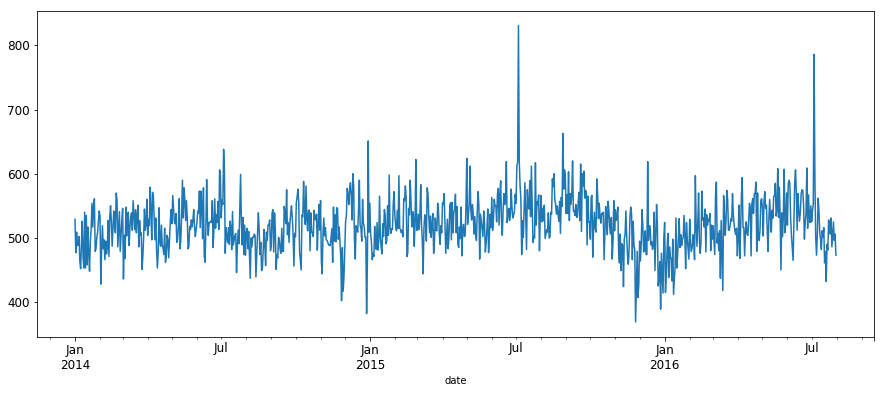

In [53]:
table.value.plot(figsize=(15,6), fontsize=12)

Видим странные большие выбросы в июле каждого года.
Найдем даты 30 самых больших выбрососв:

In [57]:
# найдем 30 наибольших выбросов и
# для лучшего анализа представим данные, игнорируя год  и сортируя по дню и месяцу
table['temp1'] = table.index.day
table['temp2'] = table.index.month
table.nlargest(50, table.columns[1]).sort_values(by=['temp1', 'temp2'])

,date,value,temp1,temp2
date,,,,
2015-05-01,2015-05-01,624,1,5
2015-07-02,2015-07-02,612,2,7
2016-06-03,2016-06-03,590,3,6
2015-07-03,2015-07-03,618,3,7
2015-07-04,2015-07-04,831,4,7
2016-07-04,2016-07-04,786,4,7
2014-07-04,2014-07-04,638,4,7
2015-09-04,2015-09-04,603,4,9
2016-03-05,2016-03-05,587,5,3


In [58]:
table.drop(columns='temp1', inplace=True)
table.drop(columns='temp2', inplace=True)

Замечаем, что некоторые конкретные даты входят в этот топ
<br>Например, 04.07 или 5.07.
<br>Заметим, что 4.07 проходин один из крупнейших праздников Independence Day
<br>Следовательно, можно считать, что это вбросы, всвязи с этим праздником
<br>Конечно будут вбросы связанные с событиями в городе, но они не будут повторяться в другие года так что их можно проигнорировать

<br>Логично предположить, что в другие праздники так же дложны происходить выбросы
<br>Проверим это, сравнив значения в определенные определенные дни(празникики) со средним по всем дням
<br>Выберем глаыне праздники в той местности:
    <br>New Year's Day - Observed, Monday, January 1 - 01.01
    <br>Martin Luther King Jr.'s Birthday - Observed, Monday, January 15 - 15.01
    <br>Lincoln's Birthday - Observed, Monday, February 12 - 12.02
    <br>Washington's Birthday - Observed, Monday, February 19 - 19.02
    <br>Memorial Day - Observed, Monday, May 28 - 28.05
    <br>Independence Day - Wednesday, July 4 - 04.07
    <br>Labor Day - Observed, Monday, September 3 - 03.09
    <br>California Admission Day holiday observed - Sunday, September 9 - 09.09
    <br>Veteran's Day holiday observed - Sunday, November 11 - 11.11
    <br>Veteran's Day - Observed, Monday, November 12 - 12.11
    <br>Thanksgiving Day holiday observed - Thursday, November 22 - 22.11
    <br>Thanksgiving - Observed, Thursday, November 22 & Friday, November 23 - 23.11
    <br>Christmas - Tuesday, December 25 - 25.12

table.mean() -  520.559915164369


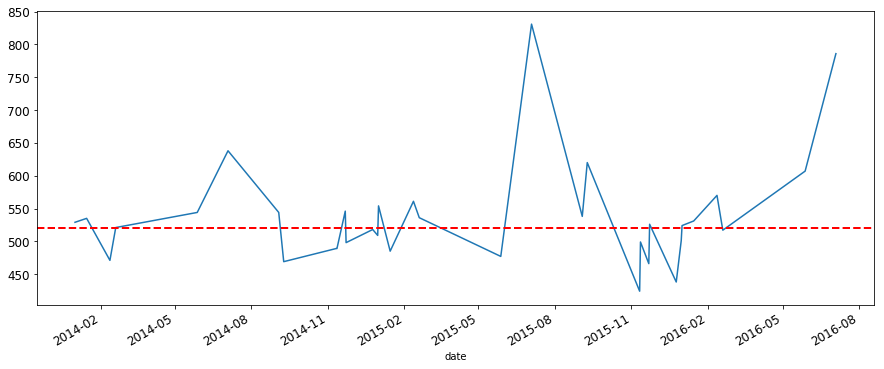

In [59]:
ax = table[((table.index.day == 1) & (table.index.month == 1)) |
      ((table.index.day == 15) & (table.index.month == 1)) |
      ((table.index.day == 12) & (table.index.month == 2)) |
      ((table.index.day == 19) & (table.index.month == 2)) |
      ((table.index.day == 28) & (table.index.month == 5)) |
      ((table.index.day == 4) & (table.index.month == 7)) |
      ((table.index.day == 3) & (table.index.month == 9)) |
      ((table.index.day == 9) & (table.index.month == 9)) |
      ((table.index.day == 11) & (table.index.month == 11)) |
      ((table.index.day == 12) & (table.index.month == 11)) |
      ((table.index.day == 22) & (table.index.month == 11)) |
      ((table.index.day == 23) & (table.index.month == 11)) |
      ((table.index.day == 25) & (table.index.month == 12)) |
      ((table.index.day == 31) & (table.index.month == 12))
     ].value.plot(figsize=(15,6), fontsize=12)

ax.axhline(y=table.mean().value, color='r', linestyle='--', lw=2)
print("table.mean() - ",table.mean().value)

Замечаем, что в некоторые праздники количество преступлений гораздо меньше среднего
<br>А в некоторые приблизительно равны среднему:
<br> давайте посмотрим что это за праздники
<br>считаем ,будем с погрешностью 3% что бы хотя бы попытаться сравнять тренды

In [60]:
t1 = table[(((table.index.day == 1) & (table.index.month == 1)) |
      ((table.index.day == 15) & (table.index.month == 1)) |
      ((table.index.day == 12) & (table.index.month == 2)) |
      ((table.index.day == 19) & (table.index.month == 2)) |
      ((table.index.day == 28) & (table.index.month == 5)) |
      ((table.index.day == 4) & (table.index.month == 7)) |
      ((table.index.day == 3) & (table.index.month == 9)) |
      ((table.index.day == 9) & (table.index.month == 9)) |
      ((table.index.day == 11) & (table.index.month == 11)) |
      ((table.index.day == 12) & (table.index.month == 11)) |
      ((table.index.day == 22) & (table.index.month == 11)) |
      ((table.index.day == 23) & (table.index.month == 11)) |
      ((table.index.day == 25) & (table.index.month == 12)) |
      ((table.index.day == 31) & (table.index.month == 12)))
     ]

In [61]:
#Cильно меньше среднего:
t1[t1.value < table.mean().value*0.97]

,date,value
date,,
2014-02-12,2014-02-12,471
2014-09-09,2014-09-09,469
2014-11-11,2014-11-11,489
2014-11-12,2014-11-12,489
2014-11-23,2014-11-23,498
2015-01-15,2015-01-15,485
2015-05-28,2015-05-28,477
2015-11-11,2015-11-11,424
2015-11-12,2015-11-12,499


<br>Veteran's Day holiday observed - Sunday, November 11 - 11.11
<br>Veteran's Day - Observed, Monday, November 12 - 12.11

In [62]:
#Приблизительно равно:
t1[(t1.value > table.mean().value*0.97)&(t1.value < table.mean().value*1.03)]

,date,value
date,,
2014-01-01,2014-01-01,529
2014-01-15,2014-01-15,535
2014-02-19,2014-02-19,521
2014-12-25,2014-12-25,518
2014-12-31,2014-12-31,509
2015-02-19,2015-02-19,536
2015-11-23,2015-11-23,526
2016-01-01,2016-01-01,524
2016-01-15,2016-01-15,531


<br>New Year's Day - Observed, Monday, January 1 - 01.01
<br>Martin Luther King Jr.'s Birthday - Observed, Monday, January 15 - 15.01
<br>Washington's Birthday - Observed, Monday, February 19 - 19.02

<br>Можно сделать вывод, что в большинстве случаев в праздники количество преступлений выше среднего
<br>В некоторые примерно столько же, сколько и обычно 
<br>Однако в некоторые значительно меньше(например 11.11 - Veteran's Day) количество преступлений значительно падает
<br>Эту информацию можно использовать что бы статически вносить правки в предсказания на дни праздников
<br> Так же можно кластеризовать праздники в зависимости от количества преступлений и использовать эту кластеризацию как характеристику праздника

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B15DC89C50>]],
      dtype=object)

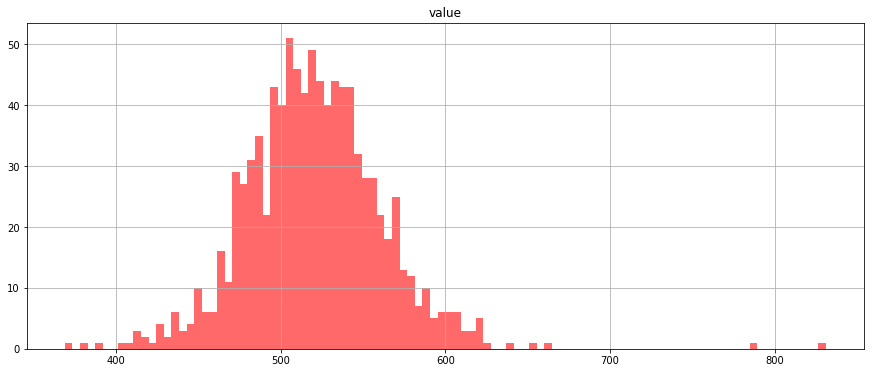

In [63]:
table.hist(bins=100, color= 'r', alpha=0.59, figsize=(15,6)) 

<br>Гистограмма по виду близка к нормальному распределению
<br>Можно обратить внимание, что в целом, количество преступлений составляет 500 гистограмма имеет очень крутые уклоны
Это значит, что в среднем количество преступлений весьма стационарно(хотя это можно заметить и просто по построению всех дней)

Теперь попробуем выяснить влияет ли время года на количество совершаемых преступлений
<br>
<br> Для этого разобъем датасет на сезоны и рассмотрим среднее число преступлений на этих участках.

C:\Users\Artem\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


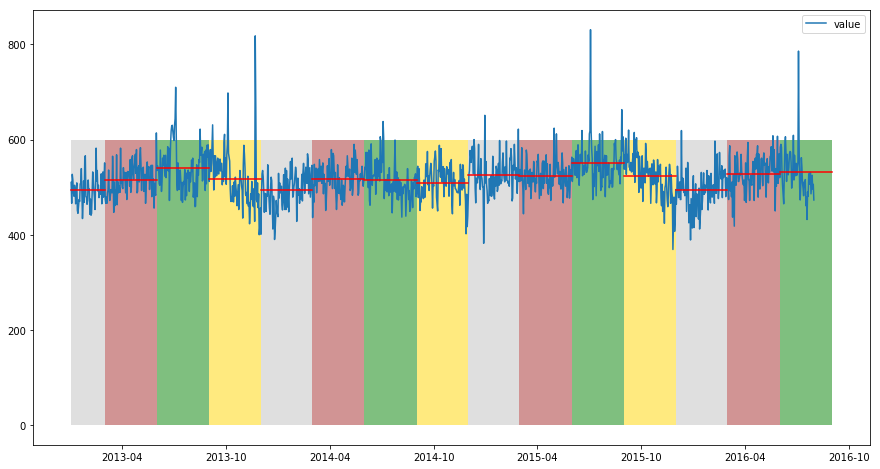

In [32]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(table.value)

winter = pd.date_range(start='1/1/2013', end='3/1/2013', freq='D')
ax1.fill_between(winter, 600, facecolor='silver', alpha=0.5)
m = table.value.loc[winter].mean()
ax1.plot(winter, [m] * winter.shape[0], 'r')

spring = pd.date_range(start='3/1/2013', end='6/1/2013', freq='D')
ax1.fill_between(spring, 600, facecolor='brown', alpha=0.5)
m = table.value.loc[spring].mean()
ax1.plot(spring, [m] * spring.shape[0], 'r')

summer = pd.date_range(start='6/1/2013', end='9/1/2013', freq='D')
ax1.fill_between(summer, 600, facecolor='green', alpha=0.5)
m = table.value.loc[summer].mean()
ax1.plot(summer, [m] * summer.shape[0], 'r')

autumn = pd.date_range(start='9/1/2013', end='12/1/2013', freq='D')
ax1.fill_between(autumn, 600, facecolor='gold', alpha=0.5)
m = table.value.loc[autumn].mean()
ax1.plot(autumn, [m] * autumn.shape[0], 'r')


winter = pd.date_range(start='12/1/2013', end='3/1/2014', freq='D')
ax1.fill_between(winter, 600, facecolor='silver', alpha=0.5)
m = table.value.loc[winter].mean()
ax1.plot(winter, [m] * winter.shape[0], 'r')

spring = pd.date_range(start='3/1/2014', end='6/1/2014', freq='D')
ax1.fill_between(spring, 600, facecolor='brown', alpha=0.5)
m = table.value.loc[spring].mean()
ax1.plot(spring, [m] * spring.shape[0], 'r')

summer = pd.date_range(start='6/1/2014', end='9/1/2014', freq='D')
ax1.fill_between(summer, 600, facecolor='green', alpha=0.5)
m = table.value.loc[summer].mean()
ax1.plot(summer, [m] * summer.shape[0], 'r')

autumn = pd.date_range(start='9/1/2014', end='12/1/2014', freq='D')
ax1.fill_between(autumn, 600, facecolor='gold', alpha=0.5)
m = table.value.loc[autumn].mean()
ax1.plot(autumn, [m] * autumn.shape[0], 'r')


winter = pd.date_range(start='12/1/2014', end='3/1/2015', freq='D')
ax1.fill_between(winter, 600, facecolor='silver', alpha=0.5)
m = table.value.loc[winter].mean()
ax1.plot(winter, [m] * winter.shape[0], 'r')

spring = pd.date_range(start='3/1/2015', end='6/1/2015', freq='D')
ax1.fill_between(spring, 600, facecolor='brown', alpha=0.5)
m = table.value.loc[spring].mean()
ax1.plot(spring, [m] * spring.shape[0], 'r')

summer = pd.date_range(start='6/1/2015', end='9/1/2015', freq='D')
ax1.fill_between(summer, 600, facecolor='green', alpha=0.5)
m = table.value.loc[summer].mean()
ax1.plot(summer, [m] * summer.shape[0], 'r')

autumn = pd.date_range(start='9/1/2015', end='12/1/2015', freq='D')
ax1.fill_between(autumn, 600, facecolor='gold', alpha=0.5)
m = table.value.loc[autumn].mean()
ax1.plot(autumn, [m] * autumn.shape[0], 'r')


winter = pd.date_range(start='12/1/2015', end='3/1/2016', freq='D')
ax1.fill_between(winter, 600, facecolor='silver', alpha=0.5)
m = table.value.loc[winter].mean()
ax1.plot(winter, [m] * winter.shape[0], 'r')

spring = pd.date_range(start='3/1/2016', end='6/1/2016', freq='D')
ax1.fill_between(spring, 600, facecolor='brown', alpha=0.5)
m = table.value.loc[spring].mean()
ax1.plot(spring, [m] * spring.shape[0], 'r')

summer = pd.date_range(start='6/1/2016', end='9/1/2016', freq='D')
ax1.fill_between(summer, 600, facecolor='green', alpha=0.5)
m = table.value.loc[summer].mean()
ax1.plot(summer, [m] * summer.shape[0], 'r')

ax1.legend(loc='best')
plt.show()


Видим, что осенью к земе количество падает, зимой по чуть чуть растет(наверное отходят от праздников)) а потом весной держится стационарно или растет. Летом держится в целом стационарно.

Попробуем найти сезонность и тренд:

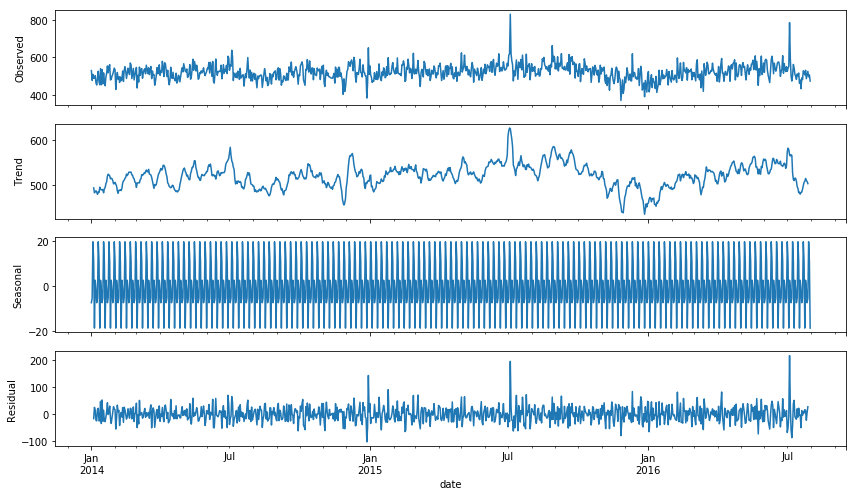

In [64]:
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(table.value).plot()
plt.show()

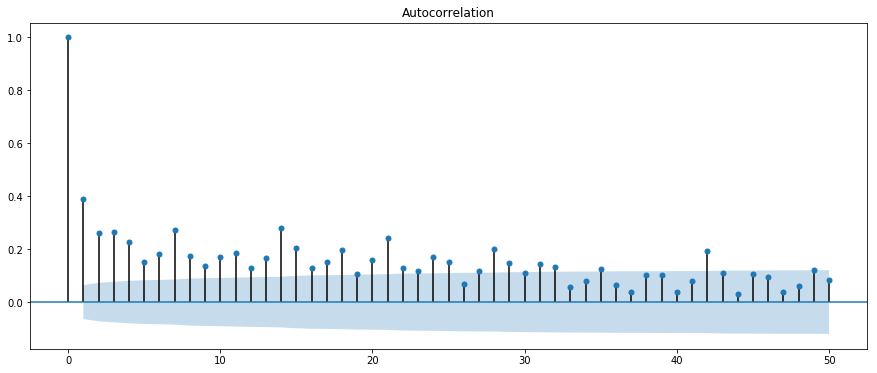

In [65]:
fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(table.value, lags=50, ax = ax)
plt.show()

Как видим у ряда выражена сезонность но не вырожен тренд. 
<br>По автокорреляции можно сказать, что сезонность составляет 7 дней.
<br>Можно еще заметить некоторый подтренд, который повторяется дважды в неделю(3 и 4 дня поочередно)

# Попробуем предсказать отрезок времени.

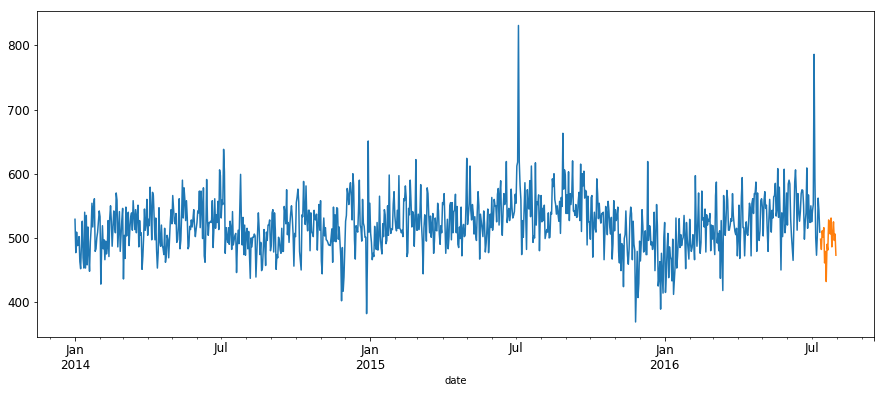

In [66]:
# для начала разобьем датасет на обучающую и тетовую выборки
# и построим их для наглядного понмания
train = table.iloc[:-20]
test = table.iloc[-20:]

# здесь будем хранить предсказания
y = test.copy()

train.value.plot( figsize=(15,6), fontsize=12)
test.value.plot( figsize=(15,6),fontsize=12)

## Рассмотрим наивный подход: завтра = вчера
<br>По графику очевидно, что этот подход даст не очень большую погрешность в одни промедутки времени, но просто гигантскую в другие(например при резком падении которые наблюдаются в Jul 2014 или Jan 2016)
<br>
<br> Но для чистоты эксперимента конечно построим эту модель

26.936035343012154


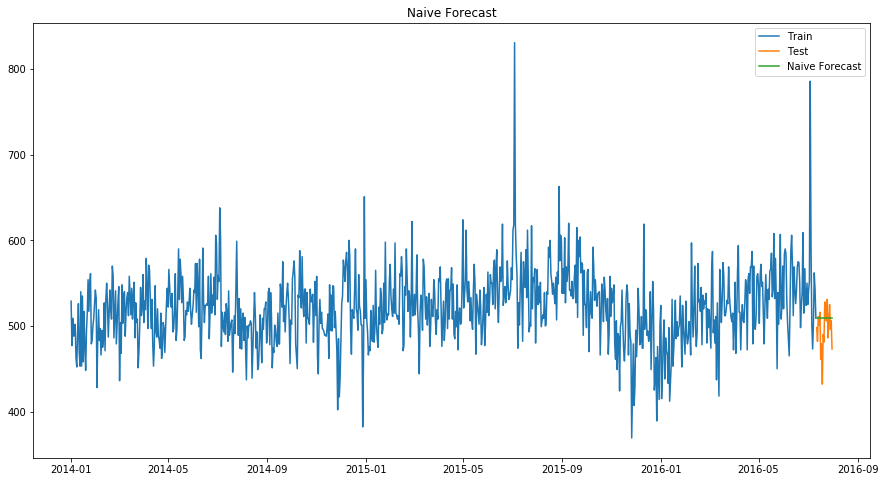

In [67]:
y['naive'] = train.value[-1]
plt.figure(figsize=(15,8))
plt.plot(train.index, train.value, label='Train')
plt.plot(test.index,test.value, label='Test')
plt.plot(y.index,y['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
print(sqrt(mean_squared_error(test.value, y.naive)))
plt.show()

Видим весьма неплохую оценку,но это только потому что наше тестирование попало на удачный отрезок.
<br>
<br>Для примера построим предсказание для большего тестового ряда(что бы большой уклон попал в предсказываемую часть)

61.44224930778495


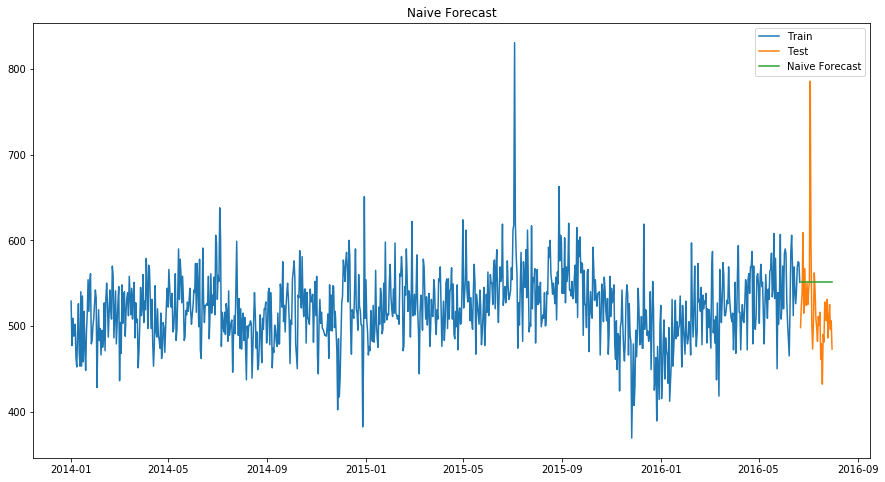

In [68]:
train1 = table.iloc[:-40]
test1 = table.iloc[-40:]
y1 = test1.copy()
y1['naive'] = train1.value[-1]
plt.figure(figsize=(15,8))
plt.plot(train1.index, train1.value, label='Train')
plt.plot(test1.index,test1.value, label='Test')
plt.plot(y1.index,y1['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
print(sqrt(mean_squared_error(test1.value, y1.naive)))
plt.show()

Видим, что ошибка резко возрасла, что нам конечно же не хочется видеть

## Теперь рассмотрим метод Холта-Уинтерса

51.77765190169041


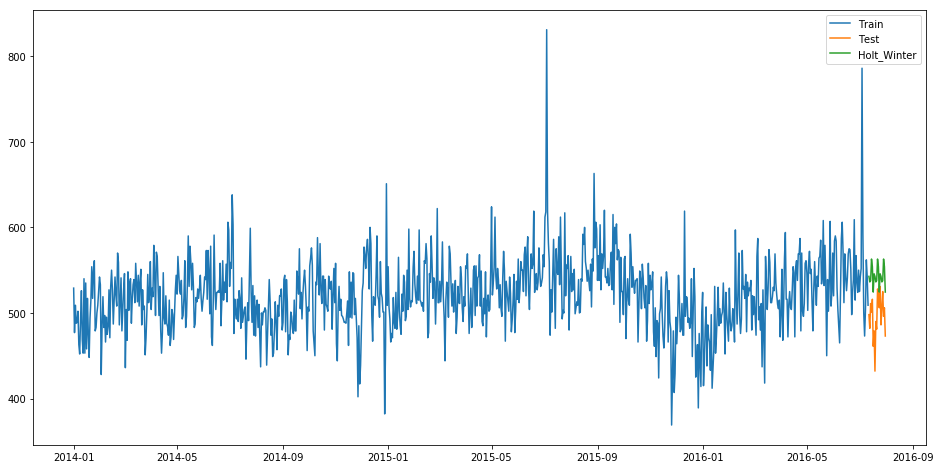

In [70]:
# выше видим, что у нас есть сезональность, но нет тренда
fit1 = ExponentialSmoothing(np.asarray(train.value) ,seasonal_periods=7 ,trend=None, seasonal='add',).fit()
y['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.value, label='Train')
plt.plot(test.value, label='Test')
plt.plot(y['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
print(sqrt(mean_squared_error(test.value, y.Holt_Winter)))
plt.show()

Ошибка достаточно большая, хотя и меньше чем у наивного подхода.

## SARIMA

Для начала сделаем ряд стационарным

In [82]:
train_diff = train.value.diff(periods=7).dropna()

In [83]:
stat_test = sm.tsa.adfuller(train_diff)
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -9.001559649585763
p-value:  6.4766932433361876e-15
Critical values:  {'1%': -3.4376857669714957, '5%': -2.864778351359889, '10%': -2.5684943199755765}
единичных корней нет, ряд стационарен


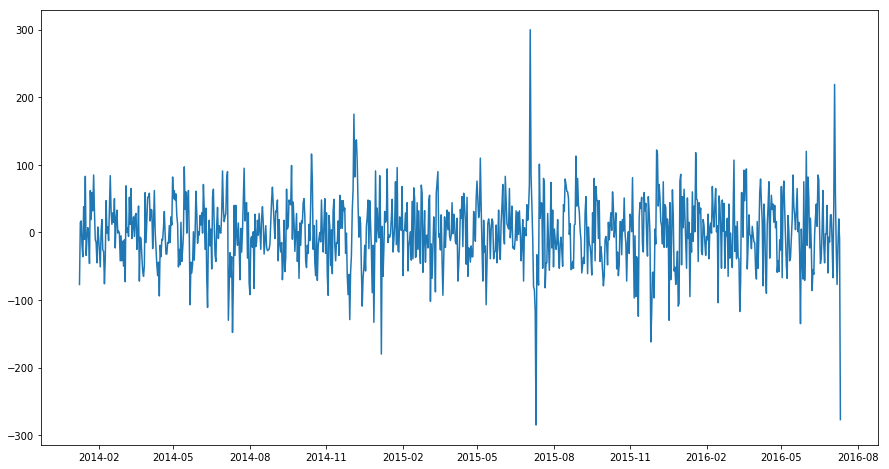

In [84]:
plt.figure(figsize=(15,8))
plt.plot(train_diff, label='Train')
plt.show()

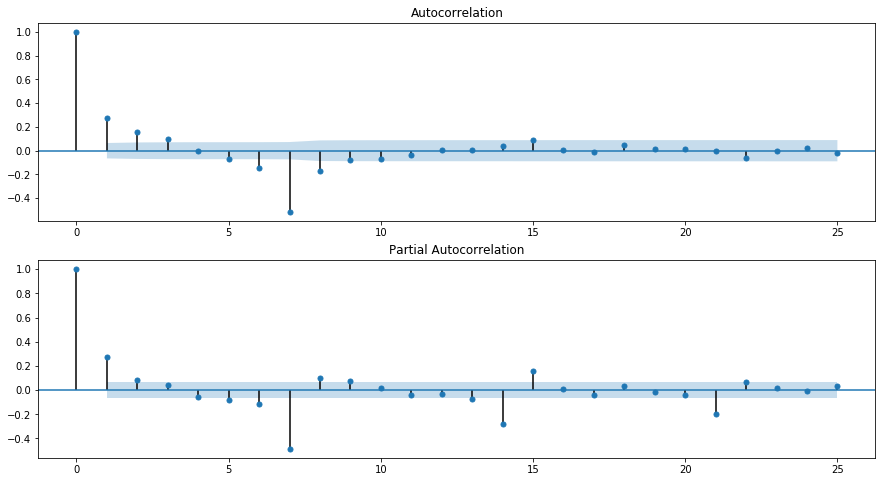

In [86]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_diff, lags=25, ax=ax2)

подберем параметры:

In [117]:
#ACF
q = 2
Q = 1
#PACF
p = 15
P = 1

d = 0
D = 1
s = 7

In [118]:
best_model=sm.tsa.statespace.SARIMAX(train.value.squeeze(), order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()

C:\Users\Artem\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Artem\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


48.10990326376206


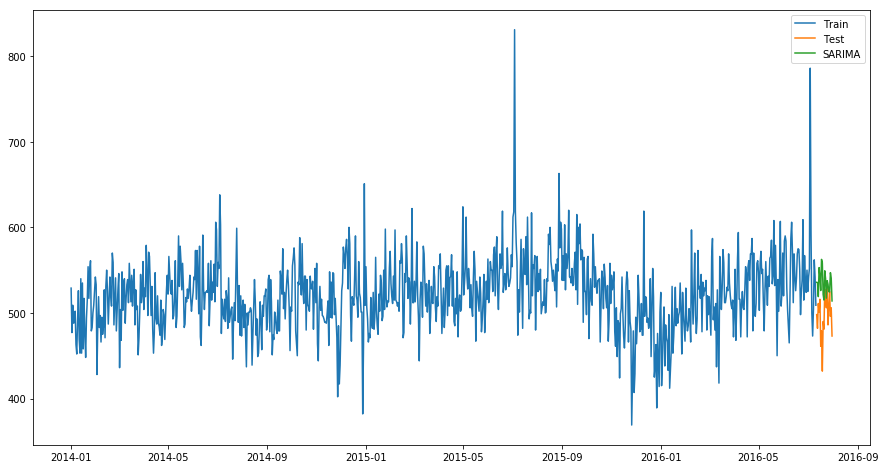

In [119]:
y_r = best_model.predict(start = train.shape[0], end = train.shape[0] + test.shape[0]-1)

predict = pd.Series(data=y_r, index=test.index)
plt.figure(figsize=(15,8))
plt.plot(train.value, label='Train')
plt.plot(test.value, label='Test')
plt.plot(predict, label='SARIMA')
print(sqrt(mean_squared_error(test.value, y_r)))
plt.legend(loc='best')
plt.show()

Заметим, что даже так мы не получили желаемого эффекта. Возможно можно лучше подобрать параметры

# Рассмотрим различные статистические гипотезы:

## Normality Tests

Проверяет, имеют ли данные распределение Гаусса:

In [129]:
#Shapiro-Wilk Test
from scipy.stats import normaltest
print(normaltest(table.value))
#D’Agostino’s K^2 Test
from scipy.stats import shapiro
print(shapiro(table.value))
#Anderson-Darling Test
from scipy.stats import anderson
print(anderson(table.value))

NormaltestResult(statistic=169.9643986953336, pvalue=1.237940476967876e-37)
(0.9640318751335144, 1.7276297444501418e-14)
AndersonResult(statistic=2.3323951500963176, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


На основании теста можно отказаться от этой гипотезы, хотя на гистограмме получается похожее распределение.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B15B4500B8>]],
      dtype=object)

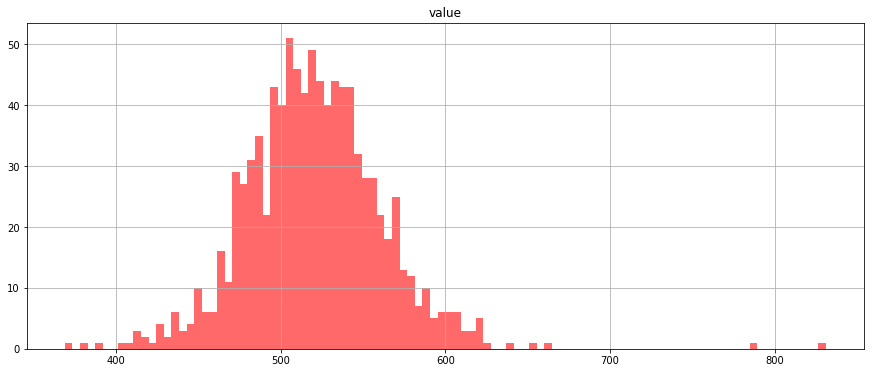

In [130]:
table.hist(bins=100, color= 'r', alpha=0.59, figsize=(15,6)) 

## Время года

Сформулируем гипотезу о том, что количество преступлений не зависит от врменеи года:

C:\Users\Artem\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


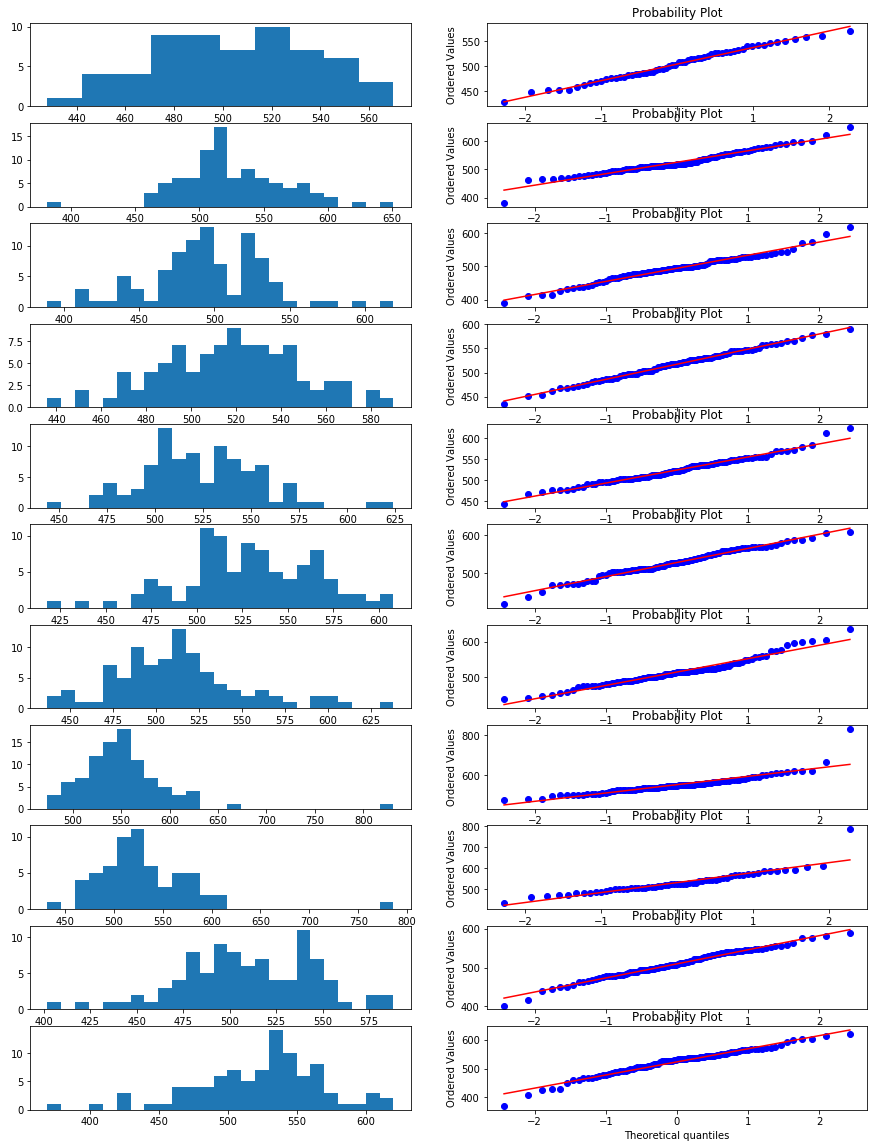

In [163]:
from scipy import stats
#разобьем на времена года
winter1 = table.loc[pd.date_range(start='1/1/2014', end='3/1/2014', freq='D')].dropna()
spring1 = table.loc[pd.date_range(start='3/1/2014', end='6/1/2014', freq='D')].dropna()
summer1 = table.loc[pd.date_range(start='6/1/2014', end='9/1/2014', freq='D')].dropna()
autumn1 = table.loc[pd.date_range(start='9/1/2014', end='12/1/2014', freq='D')].dropna()
winter2 = table.loc[pd.date_range(start='12/1/2014', end='3/1/2015', freq='D')].dropna()
spring2 = table.loc[pd.date_range(start='3/1/2015', end='6/1/2015', freq='D')].dropna()
summer2 = table.loc[pd.date_range(start='6/1/2015', end='9/1/2015', freq='D')].dropna()
autumn2 = table.loc[pd.date_range(start='9/1/2015', end='12/1/2015', freq='D')].dropna()
winter3 = table.loc[pd.date_range(start='12/1/2015', end='3/1/2016', freq='D')].dropna()
spring3 = table.loc[pd.date_range(start='3/1/2016', end='6/1/2016', freq='D')].dropna()
summer3 = table.loc[pd.date_range(start='6/1/2016', end='9/1/2016', freq='D')].dropna()
#проверим распределение
fig, axes = plt.subplots(11, 2)
fig.set_figheight(20)
fig.set_figwidth(15)


axes[0, 0].hist(winter1.value)
stats.probplot(winter1.value, dist = "norm", plot = axes[0, 1])

axes[1, 0].hist(winter2.value, 25)
stats.probplot(winter2.value, dist = "norm", plot = axes[1, 1])

axes[2, 0].hist(winter3.value, 25)
stats.probplot(winter3.value, dist = "norm", plot = axes[2, 1])

axes[3, 0].hist(spring1.value, 25)
stats.probplot(spring1.value, dist = "norm", plot = axes[3, 1])

axes[4, 0].hist(spring2.value, 25)
stats.probplot(spring2.value, dist = "norm", plot = axes[4, 1])

axes[5, 0].hist(spring3.value, 25)
stats.probplot(spring3.value, dist = "norm", plot = axes[5, 1])

axes[6, 0].hist(summer1.value, 25)
stats.probplot(summer1.value, dist = "norm", plot = axes[6, 1])

axes[7, 0].hist(summer2.value, 25)
stats.probplot(summer2.value, dist = "norm", plot = axes[7, 1])

axes[8, 0].hist(summer3.value, 25)
stats.probplot(summer3.value, dist = "norm", plot = axes[8, 1])

axes[9, 0].hist(autumn1.value, 25)
stats.probplot(autumn1.value, dist = "norm", plot = axes[9, 1])

axes[10, 0].hist(autumn2.value, 25)
stats.probplot(autumn2.value, dist = "norm", plot = axes[10, 1])

plt.subplots_adjust()


Видим, что по каждому из сезонов распределение нормально<br>
Проверяем гипотезу о том, что имеют одинаковое среднее:

In [164]:
stats.f_oneway(winter1.value, 
               winter2.value,
               winter3.value,
               summer1.value,
               summer2.value,
               summer3.value,
               spring1.value,
               spring2.value,
               spring3.value,
               autumn1.value,
               autumn2.value)

F_onewayResult(statistic=13.062815942839908, pvalue=1.3389314618117005e-21)

In [165]:
from scipy import stats
stats.kruskal(winter1.value, 
               winter2.value,
               winter3.value,
               summer1.value,
               summer2.value,
               summer3.value,
               spring1.value,
               spring2.value,
               spring3.value,
               autumn1.value,
               autumn2.value)

KruskalResult(statistic=117.44207964952913, pvalue=1.670402812234698e-20)

Односторонний ANOVA проверяет нулевую гипотезу о том, что две или более группы имеют одно и то же среднее значение.
<br>for_check = 0.05*2/11! = 2.5052108385441724*^-9
<br>pvalue < for_check
<br>следовательно наша гипотеза неверна и сезон влияет на количество преступлений доставки

# Вывод

<br> Мы провели анализ количества преступлений в штате.
<br> В итоге мы установили, что праздники оказывают существенное влияние на количество преступлений
<br> (Особенно выделется 4.07 так как там происходит просто гигантский скачок количества преступлений)
<br> Так же было замечено, что количество преступлений зависит от сезона и приблизительно установиили эту зависимость
<br> Было установленно, что так же существует недельная сезональность
<br> В конце мы построили предсказания для разных моделей, ни одна из которых не дала желаемого результата